In [1]:
%run additional.ipynb

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
pandas.set_option('display.max_colwidth', 120)

In [4]:
PROFILE = 'ssh-py2'

# HLT2 nbody classification

did preselections:

* any sv.n, 
* any sv.minpt
* sv.nlt16 < 2

## Training channels (read data)

We will use just 11114001, 11296013, 11874042, 12103035, 13246001, 13264021

In [5]:
sig_train_modes_names = [11114001, 11296013, 11874042, 12103035, 13246001, 13264021]
bck_train_mode_name = 30000000
sig_train_files = ['mod_{}.csv'.format(name) for name in sig_train_modes_names]
bck_train_files = 'mod_30000000.csv'
folder = "datasets/prepared_hlt_body/"

In [6]:
# concat all signal data
if not os.path.exists(folder + 'signal_hlt2.csv'):
    concat_files(folder, sig_train_files, os.path.join(folder , 'signal_hlt2.csv'))

In [7]:
signal_data = pandas.read_csv(os.path.join(folder , 'signal_hlt2.csv'), sep='\t')
bck_data = pandas.read_csv(os.path.join(folder , bck_train_files), sep='\t')

In [8]:
signal_data.columns

Index([u'unique', u'mode', u'event_number', u'sv_number', u'pass_2body',
       u'pass_nbody', u'signal', u'sumpt', u'm', u'mcor', u'ipchi2', u'chi2',
       u'sumipchi2', u'fdr', u'nlt16', u'minpt', u'eta', u'pt', u'nmu', u'n',
       u'fdchi2', u'maxtchi2', u'ngood', u'nmu1', u'mupt', u'n1trk', u'sig',
       u'idx'],
      dtype='object')

## Counting events and svrs,
that passed **L0** and **GoodGenB** preselection (this data was generated by skim)

In [9]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 12367085, 'Events': 166059}
Bck {'SVR': 408147, 'Events': 38035}


In [10]:
total_bck_events = statistic_length(bck_data)['Events'] + empty_events[bck_train_mode_name]
total_signal_events_by_mode = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events'] + empty_events[mode]

### events distribution by mode

In [11]:
print 'Bck:', total_bck_events
'Signal:', total_signal_events_by_mode

Bck: 111306


('Signal:',
 {11114001: 61102,
  11296013: 17149,
  11874042: 3942,
  12103035: 25250,
  13246001: 37313,
  13264021: 25165})

## Define variables

In [12]:
variables = ["n", "mcor", "chi2", "eta", "fdchi2", "minpt", "nlt16", "ipchi2", "n1trk", "sumpt"]

## Counting events and svrs,

which passed **pass_nbody** (equivalent Mike's preselections for nbody selection)

In [13]:
# hlt2 nbody selection
signal_data = signal_data[(signal_data['pass_nbody'] == 1) & (signal_data['mcor'] <= 10e3)]
bck_data = bck_data[(bck_data['pass_nbody'] == 1) & (bck_data['mcor'] <= 10e3)]

In [14]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 960600, 'Events': 150566}
Bck {'SVR': 21868, 'Events': 9664}


In [15]:
total_signal_events_by_mode_presel = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode_presel[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events']
total_bck_events_presel = statistic_length(bck_data)['Events']

### events distribution by mode

In [16]:
print 'Bck:', total_bck_events_presel
'Signal:', total_signal_events_by_mode_presel

Bck: 9664


('Signal:',
 {11114001: 53105,
  11296013: 16256,
  11874042: 3290,
  12103035: 21498,
  13246001: 33807,
  13264021: 22610})

In [17]:
signal_data.head()

,unique,mode,event_number,sv_number,pass_2body,pass_nbody,signal,sumpt,m,mcor,...,nmu,n,fdchi2,maxtchi2,ngood,nmu1,mupt,n1trk,sig,idx
1,11114001_0,11114001,0,1,1,1,1,6912.10,2806.110,4168.77,...,1,2,9653.910,1.20832,2,1,2972.750,2,1,1
2,11114001_0,11114001,0,2,1,1,1,3731.68,728.895,4429.24,...,2,2,7424.620,1.58733,2,2,2972.750,1,1,2
3,11114001_0,11114001,0,3,1,1,1,4698.27,1249.280,2144.50,...,1,2,1382.720,1.58733,2,1,758.924,1,1,3
5,11114001_1,11114001,1,1,1,1,1,4003.36,3530.930,4651.29,...,1,2,1102.850,1.20808,2,1,2611.970,2,1,1
9,11114001_1,11114001,1,5,1,1,1,2145.67,1520.500,2266.15,...,1,2,868.049,1.35907,2,1,1137.010,2,1,5


## Prepare train/test splitting

Divide events which passed alll preselections into two equal parts randomly

In [18]:
ds_train_signal, ds_train_bck, ds_test_signal, ds_test_bck = prepare_data(signal_data, bck_data, 'unique')

### train: counting events and svrs

In [19]:
print 'Signal', statistic_length(ds_train_signal)
print 'Bck', statistic_length(ds_train_bck)

Signal {'SVR': 479851, 'Events': 75283}
Bck {'SVR': 10759, 'Events': 4832}


In [20]:
train = pandas.concat([ds_train_bck, ds_train_signal])

### test: counting events and svrs

In [21]:
print 'Signal', statistic_length(ds_test_signal)
print 'Bck', statistic_length(ds_test_bck)

Signal {'SVR': 480749, 'Events': 75283}
Bck {'SVR': 11109, 'Events': 4832}


In [22]:
test = pandas.concat([ds_test_bck, ds_test_signal])

## Define all total events in test samples
(which passed just l0 and goodgenB) using also empty events. Suppose that events which didn't pass **pass_nboby** also were equal randomly divided into training and test samples 

In [23]:
total_test_bck_events = (total_bck_events - total_bck_events_presel) // 2 + statistic_length(ds_test_bck)['Events']
total_test_signal_events = dict()
for mode in sig_train_modes_names:
    total_not_passed_signal = total_signal_events_by_mode[mode] - total_signal_events_by_mode_presel[mode]
    total_test_signal_events[mode] = total_not_passed_signal // 2 + \
        statistic_length(ds_test_signal[ds_test_signal['mode'] == mode])['Events']

In [24]:
print 'Bck total test events:', total_test_bck_events
'Signal total test events:', total_test_signal_events

Bck total test events: 55653


('Signal total test events:',
 {11114001: 30533,
  11296013: 8630,
  11874042: 1950,
  12103035: 12682,
  13246001: 18627,
  13264021: 12537})

In [25]:
import cPickle
if os.path.exists('models/prunned.pkl'):
    with open('models/prunned.pkl', 'r') as file_pr:
        estimators = cPickle.load(file_pr)

# Matrixnet training

In [26]:
from rep_ef.estimators import MatrixNetClassifier

In [27]:
params = {'connection_auth': 'AUTH_HEADERS', 'connection': 'skygrid', 'regularization': 0.02,
          'sync': False, "iterations": 5000}

### Base model with 5000 trees

In [28]:
ef_base = MatrixNetClassifier(train_features=variables, **params)
ef_base.fit(train, train['signal'])

MatrixNetClassifier(auto_stop=None, baseline_feature=None,
          command_line_params=None, connection='skygrid',
          connection_auth='AUTH_HEADERS', dump_filename=None,
          features_sample_rate_per_iteration=1.0, intervals=64,
          iterations=5000, max_features_per_iteration=6,
          regularization=0.02, sync=False,
          train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
          training_fraction=0.5)

### DT

In [29]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

In [30]:
from rep.estimators import SklearnClassifier
tt_base = SklearnClassifier(DecisionTrainClassifier(learning_rate=0.02, n_estimators=10000, 
                                                    depth=6, pretransform_needed=True, 
                                                    max_features=6, loss=LogLossFunction(regularization=100)),
                            features=variables)
tt_base.fit(train, train['signal'])
pass

### Base BBDT model

In [31]:
special_b = {
'n': [2.5, 3.5],
'mcor': [2000,3000,4000,5000,7500],  # I want to remove splits too close the the B mass as I was looking in simulation and this could distort the mass peak (possibly)
'chi2': [1,2.5,5,7.5,10,100],  # I also propose we add a cut to the pre-selection of chi2 < 1000.  I don't want to put in splits at too small values here b/c these type of inputs are never modeled quite right in the simulation (they always look a bit more smeared in data).
'sumpt': [3000,4000,5000,6000,7500,9000,12e3,23e3,50e3],  # I am happy with the MN splits here (these are almost "as is" from modify-6)
'eta': [2.5,3,3.75,4.25,4.5], # Close to MN.  
'fdchi2': [33,125,350,780,1800,5000,10000],  # I want to make the biggest split 10e3 because in the simulated events there is pretty much only BKGD above 40e3 but we don't want the BDT to learn to kill these as new particles would live here.   Otherwise I took the MN splits and modified the first one (the first one is 5sigma now).
'minpt': [350,500,750,1500,3000,5000],   # let's make 500 the 2nd split so that this lines up with the HLT1 SVs.
'nlt16': [0.5],
'ipchi2': [8,26,62,150,500,1000],  # I also propose we add a cut of IP chi2 < 5000 as it's all background out there.  
'n1trk': [0.5, 1.5, 2.5, 3.5]
}

ef_base_bbdt = MatrixNetClassifier(train_features=variables, intervals=special_b, **params)
ef_base_bbdt.fit(train, train['signal'])

MatrixNetClassifier(auto_stop=None, baseline_feature=None,
          command_line_params=None, connection='skygrid',
          connection_auth='AUTH_HEADERS', dump_filename=None,
          features_sample_rate_per_iteration=1.0,
          intervals={'sumpt': [3000, 4000, 5000, 6000, 7500, 9000, 12000.0, 23000.0, 50000.0], 'eta': [2.5, 3, 3.75, 4.25, 4.5], 'minpt': [350, 500, 750, 1500, 3000, 5000], 'chi2': [1, 2.5, 5, 7.5, 10, 100], 'n1trk': [0.5, 1.5, 2.5, 3.5], 'nlt16': [0.5], 'mcor': [2000, 3000, 4000, 5000, 7500], 'fdchi2': [33, 125, 350, 780, 1800, 5000, 10000], 'ipchi2': [8, 26, 62, 150, 500, 1000], 'n': [2.5, 3.5]},
          iterations=5000, max_features_per_iteration=6,
          regularization=0.02, sync=False,
          train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
          training_fraction=0.5)

### BBDT-5, 6

In [32]:
ef_base_bbdt5 = MatrixNetClassifier(train_features=variables, intervals=5, **params)
ef_base_bbdt5.fit(train, train['signal'])

ef_base_bbdt6 = MatrixNetClassifier(train_features=variables, intervals=6, **params)
ef_base_bbdt6.fit(train, train['signal'])

MatrixNetClassifier(auto_stop=None, baseline_feature=None,
          command_line_params=None, connection='skygrid',
          connection_auth='AUTH_HEADERS', dump_filename=None,
          features_sample_rate_per_iteration=1.0, intervals=6,
          iterations=5000, max_features_per_iteration=6,
          regularization=0.02, sync=False,
          train_features=['n', 'mcor', 'chi2', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk', 'sumpt'],
          training_fraction=0.5)

# Pruning

In [33]:
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
report = ClassificationReport({'base': ef_base}, LabeledDataStorage(test, test['signal']))

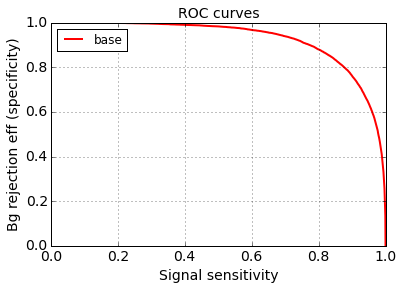

In [34]:
report.roc()

## Minimize log_loss
он же BinomialDeviance

In [35]:
%run pruning.py

### Training sample is cut to be aliquot 8

In [ ]:
new_trainlen = (len(train) // 8) * 8
trainX = train[ef_base.features][:new_trainlen].values
trainY = train['signal'][:new_trainlen].values 
trainW = numpy.ones(len(trainY))
trainW[trainY == 0] *= sum(trainY) / sum(1 - trainY)

In [ ]:
new_features, new_formula_mx, new_classifier = select_trees(trainX, trainY, sample_weight=trainW,
                                                            initial_classifier=ef_base,
                                                            iterations=100, n_candidates=100, 
                                                            learning_rate=0.1, regularization=50.)

0 1.61980016655 0.856480024408
1 1.55855321625 0.873125278678
2 1.50288108897 0.874055848203
3 1.45649627372 0.886310704186
4 1.41521814676 0.884852874617
5 1.37659730279 0.886162293629
6 1.34339956469 0.890111304554
7 1.31230672819 0.892696436348
8 1.28418703021 0.896115326611
9 1.26016148253 0.895220992614
10 1.23863679736 0.896468569803
11 1.21859513887 0.897995121227
12 1.20073871817 0.899692087218
13 1.18405499794 0.900805875378
14 1.16874278078 0.902120397345
15 1.15530857139 0.902016312761
16 1.14309203894 0.903159739993
17 1.13162046987 0.903784971244
18 1.12096348985 0.904862249696
19 1.1107258364 0.90550598049
20 1.10142476871 0.906318870014
21 1.09287415581 0.907032086507
22 1.08477290783 0.907714709484
23 1.07664250697 0.908317091722
24 1.06971525026 0.908785665464
25 1.06324237247 0.909219794796
26 1.05727032024 0.909788935192
27 1.05150363319 0.910339684032
28 1.04593316004 0.910982553938
29 1.04050532612 0.91159593634
30 1.03566838335 0.911991689691
31 1.0311432218 0.912

In [ ]:
prunned = cPickle.loads(cPickle.dumps(ef_base))
prunned.formula_mx = new_formula_mx

In [26]:
def mode_scheme_fit(train, base, suf, model_file):
    blending_parts = OrderedDict()
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp = FoldingClassifier(base_estimator=base, random_state=11, features=variables, parallel_profile=PROFILE)
        temp_data = train[(train['mode'] == ch) | (train['mode'] == bck_train_mode_name)]
        temp.fit(temp_data, temp_data['signal'])
        blending_parts['ch' + str(n_ch) + suf] = temp
    import cPickle
    with open(model_file, 'w') as f:
        cPickle.dump(blending_parts, f)

def mode_scheme_predict(data, suf, model_file, mode='train'):
    with open(model_file, 'r') as f:
        blending_parts = cPickle.load(f)
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp_name = 'ch' + str(n_ch) + suf
        if mode == 'train':
            temp_key = ((data['mode'] == ch) | (data['mode'] == bck_train_mode_name))
            data.ix[temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[temp_key])[:, 1]
            data.ix[~temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[~temp_key])[:, 1]
        else:
            data[temp_name] = blending_parts[temp_name].predict_proba(data)[:, 1]

In [27]:
def get_best_svr_by_channel(data, feature_mask, count=1):
    add_events = []
    for id_est, channel in enumerate(sig_train_modes_names):
        train_part = data[(data['mode'] == channel)]
        for num, group in train_part.groupby('unique'):
            index = numpy.argsort(group[feature_mask.format(id_est)].values)[::-1]
            add_events.append(group.iloc[index[:count], :])
    good_events = pandas.concat([data[(data['mode'] == bck_train_mode_name)]] + add_events)
    print len(good_events)
    return good_events

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from rep.metaml import FoldingClassifier
base = RandomForestClassifier(n_estimators=500, min_samples_leaf=50, max_depth=6,
                              max_features=7, n_jobs=8)

mode_scheme_fit(train, base, '', 'forest_trick.pkl')
mode_scheme_predict(train, '', 'forest_trick.pkl')
mode_scheme_predict(test, '', 'forest_trick.pkl', mode='test')

In [ ]:
good_events = get_best_svr_by_channel(train, 'ch{}', 2)
forest_mn = MatrixNetClassifier(train_features=variables, **params)
forest_mn.fit(good_events, good_events['signal'])

In [ ]:
forest_mn_bbdt = MatrixNetClassifier(train_features=variables, intervals=special_b, **params)
forest_mn_bbdt.fit(good_events, good_events['signal'])

In [47]:
estimators = {'base MN': ef_base, 'BBDT MN-6': ef_base_bbdt6, 'BBDT MN-5': ef_base_bbdt5,
              'BBDT MN special': ef_base_bbdt,
              'Prunned MN': prunned, 'base MN + forest selection': forest_mn,
              'BBDT MN special + forest selection': forest_mn_bbdt}

In [48]:
import cPickle
with open('models/prunned.pkl', 'w') as file_pr:
    cPickle.dump(estimators, file_pr)

In [28]:
mode_scheme_predict(train, '', 'forest_trick.pkl')
mode_scheme_predict(test, '', 'forest_trick.pkl', mode='test')
good_events = get_best_svr_by_channel(train, 'ch{}', 2)

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random cl

In [32]:
forest_mn = estimators['base MN + forest selection']

In [30]:
new_trainlen = (len(good_events) // 8) * 8
trainX = good_events[forest_mn.features][:new_trainlen].values
trainY = good_events['signal'][:new_trainlen].values 
trainW = numpy.ones(len(trainY))
trainW[trainY == 0] *= sum(trainY) / sum(1 - trainY)

In [31]:
len(train), len(good_events)

(490610, 148864)

In [39]:
from pruning import select_trees

In [46]:
new_features_f, new_formula_mx_f, new_classifier_f = select_trees(trainX, trainY, sample_weight=trainW,
                                                                initial_classifier=forest_mn,
                                                                iterations=100, n_candidates=100, 
                                                                learning_rate=0.1, regularization=50.)

0 1.60078248094 0.901796905149
1 1.52151339413 0.923335602001
2 1.45169769487 0.925430655707
3 1.38572513581 0.929868796309
4 1.32994316543 0.9308060946
5 1.28017490165 0.930470533662
6 1.23693059238 0.933147934082
7 1.19733807804 0.933243381421
8 1.16132643927 0.93547865652
9 1.12857747378 0.936070199856
10 1.09906281803 0.936836527463
11 1.07390008266 0.937896664422
12 1.04995047369 0.93830805223
13 1.02835937093 0.939537035867
14 1.00868921128 0.94053319523
15 0.99108361714 0.941546669344
16 0.97523698868 0.942248871293
17 0.960297285736 0.942507713292
18 0.946642698714 0.943219483698
19 0.933986478216 0.943405763578
20 0.922620489185 0.944093222665
21 0.912081689546 0.944239921738
22 0.902090380267 0.944827631298
23 0.892963360384 0.945442713006
24 0.884106584559 0.945693410291
25 0.875886848822 0.946332267269
26 0.867880943737 0.94665000971
27 0.861124357829 0.947065475596
28 0.854806630155 0.947466419703
29 0.84850258423 0.947678416473
30 0.842509923439 0.948218496752
31 0.837212

In [74]:
prunned_f = cPickle.loads(cPickle.dumps(forest_mn))
prunned_f.formula_mx = new_formula_mx_f
estimators['Prunned MN + forest selection'] = prunned_f

In [76]:
import cPickle
with open('models/prunned.pkl', 'w') as file_pr:
    cPickle.dump(estimators, file_pr)

## Calculate thresholds on classifiers

In [77]:
thresholds = dict()
test_bck = test[test['signal'] == 0]
RATE = [2500., 4000.]
events_pass = dict()
for name, cl in estimators.items():
    prob = cl.predict_proba(test_bck)
    thr, result = calculate_thresholds(test_bck, prob, total_test_bck_events, rates=RATE)
    for rate, val in result.items():
        events_pass['{}-{}'.format(rate, name)] = val[1]
    thresholds[name] = thr
    print name, result

BBDT MN-6 {4000.0: (0.99402680780929342, 222, 0.00398900328823244), 2500.0: (0.99595672446060457, 139, 0.002497619175965357)}
BBDT MN-5 {4000.0: (0.99425757263704562, 222, 0.00398900328823244), 2500.0: (0.99628784046073426, 139, 0.002497619175965357)}
BBDT MN special + forest selection {4000.0: (0.98010418304141567, 222, 0.00398900328823244), 2500.0: (0.98834949508318237, 139, 0.002497619175965357)}
base MN + forest selection {4000.0: (0.9782512655562825, 222, 0.00398900328823244), 2500.0: (0.9871724841406837, 139, 0.002497619175965357)}
Prunned MN {4000.0: (0.76757702166905506, 222, 0.00398900328823244), 2500.0: (0.82695178735465891, 139, 0.002497619175965357)}
BBDT MN special {4000.0: (0.99441421391844975, 222, 0.00398900328823244), 2500.0: (0.99615994806063501, 139, 0.002497619175965357)}
base MN {4000.0: (0.99410103269102013, 222, 0.00398900328823244), 2500.0: (0.99610789680421596, 139, 0.002497619175965357)}
Prunned MN + forest selection {4000.0: (0.73131449868597176, 222, 0.00398

## Final efficiencies for each mode

In [58]:
train_modes_eff, statistic = result_statistic(estimators, sig_train_modes_names, 
                                              test[test['signal'] == 1],
                                              thresholds, RATE, total_test_signal_events)

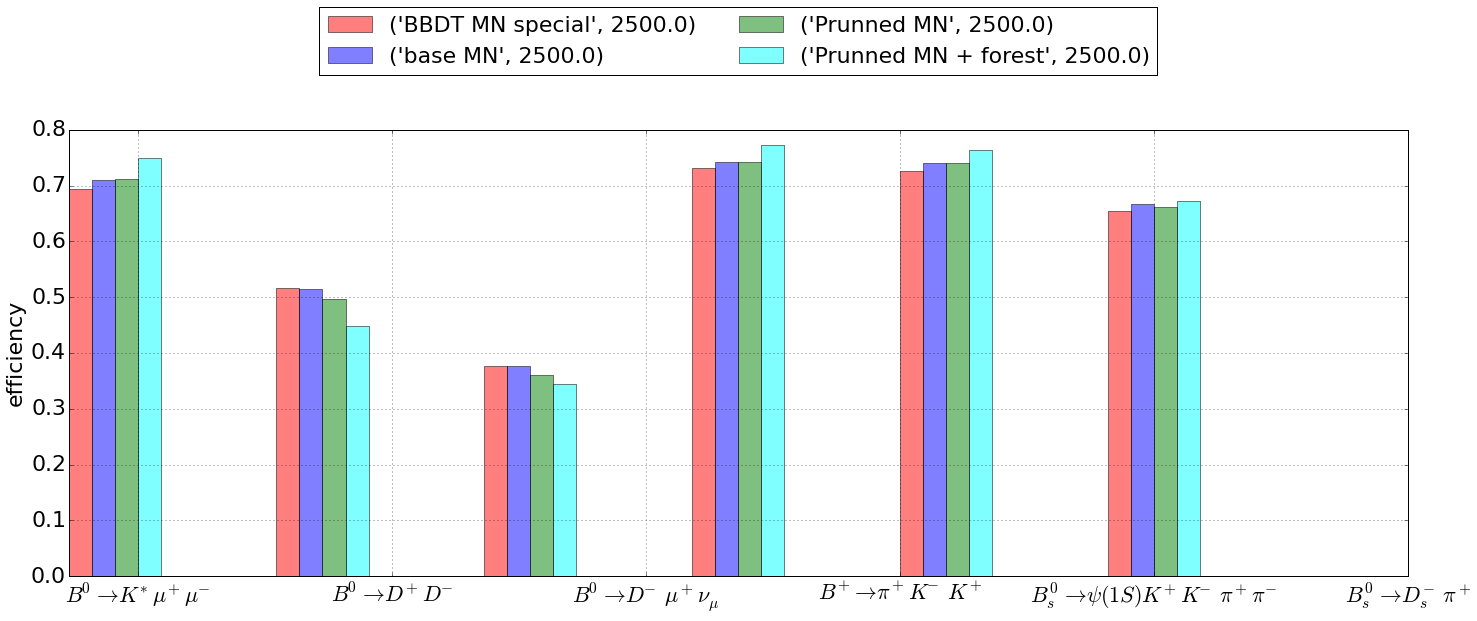

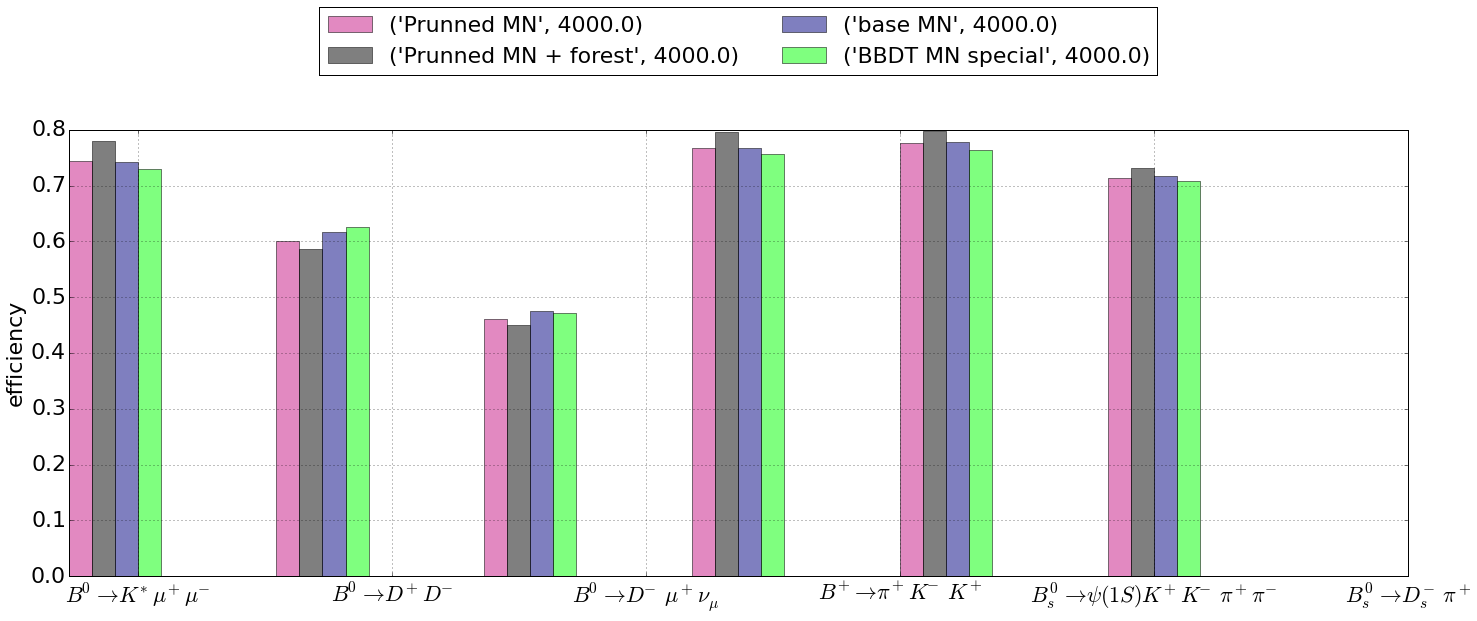

In [59]:
from rep.plotting import BarComparePlot
xticks_labels = ['$B^0 \\to K^*\mu^+\mu^-$', "$B^0 \\to D^+D^-$", "$B^0 \\to D^- \mu^+ \\nu_{\mu}$", 
                 '$B^+ \\to \pi^+ K^-K^+$', '$B^0_s \\to \psi(1S) K^+K^-\pi^+\pi^-$', '$B^0_s \\to D_s^-\pi^+$']
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if (key[0] in {'base MN', 'Prunned MN', 'BBDT MN special', 
                       'base MN + forest', 'Prunned MN + forest', 'BBDT MN special + forest'}) and r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    xticks(3 + 11 * numpy.arange(6), xticks_labels, rotation=0)
    lgd = legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

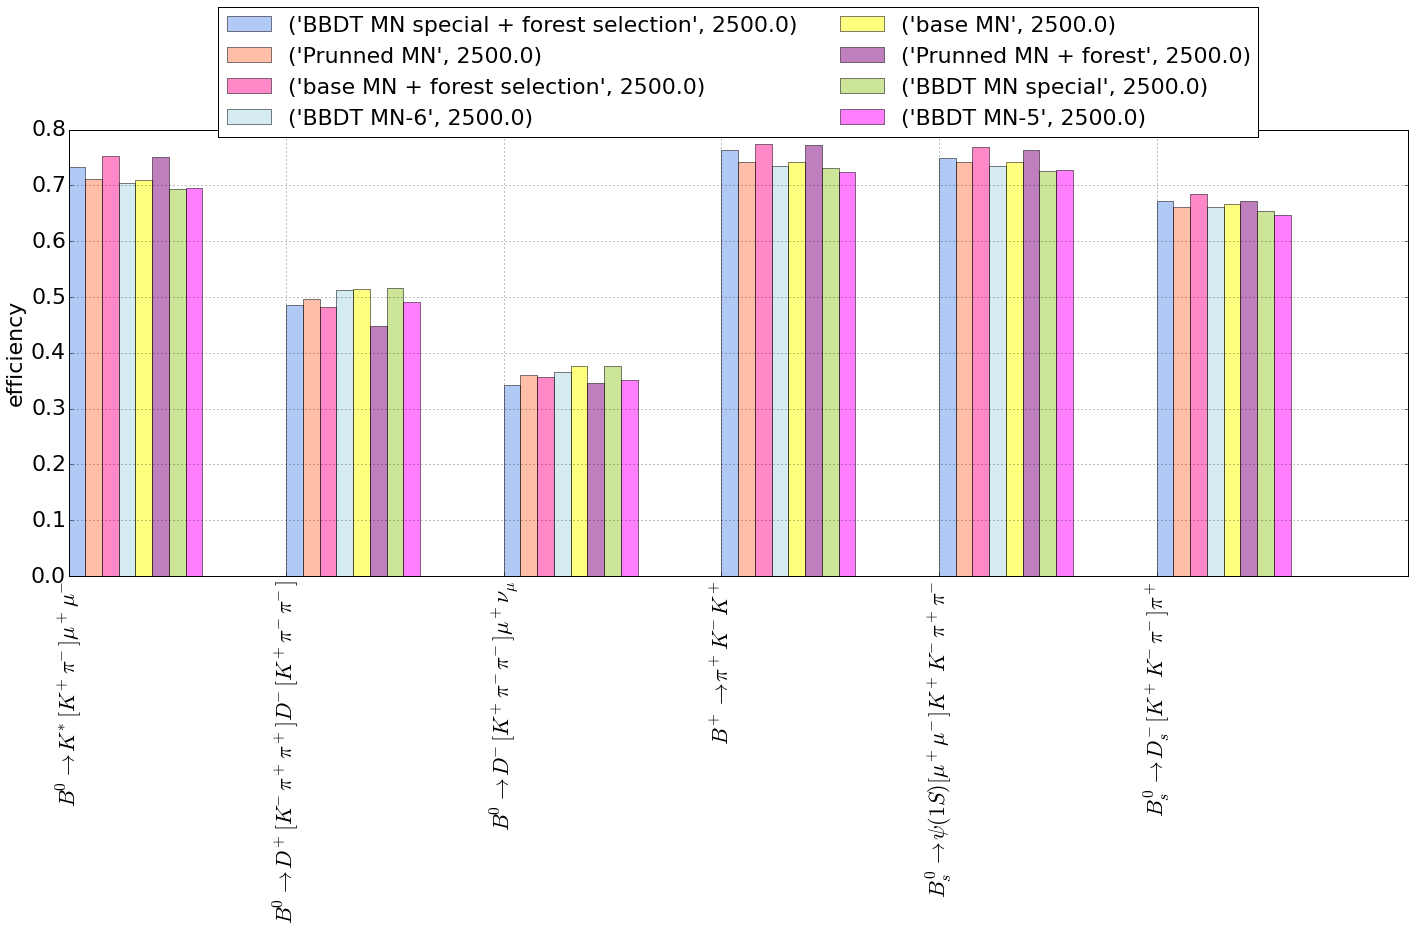

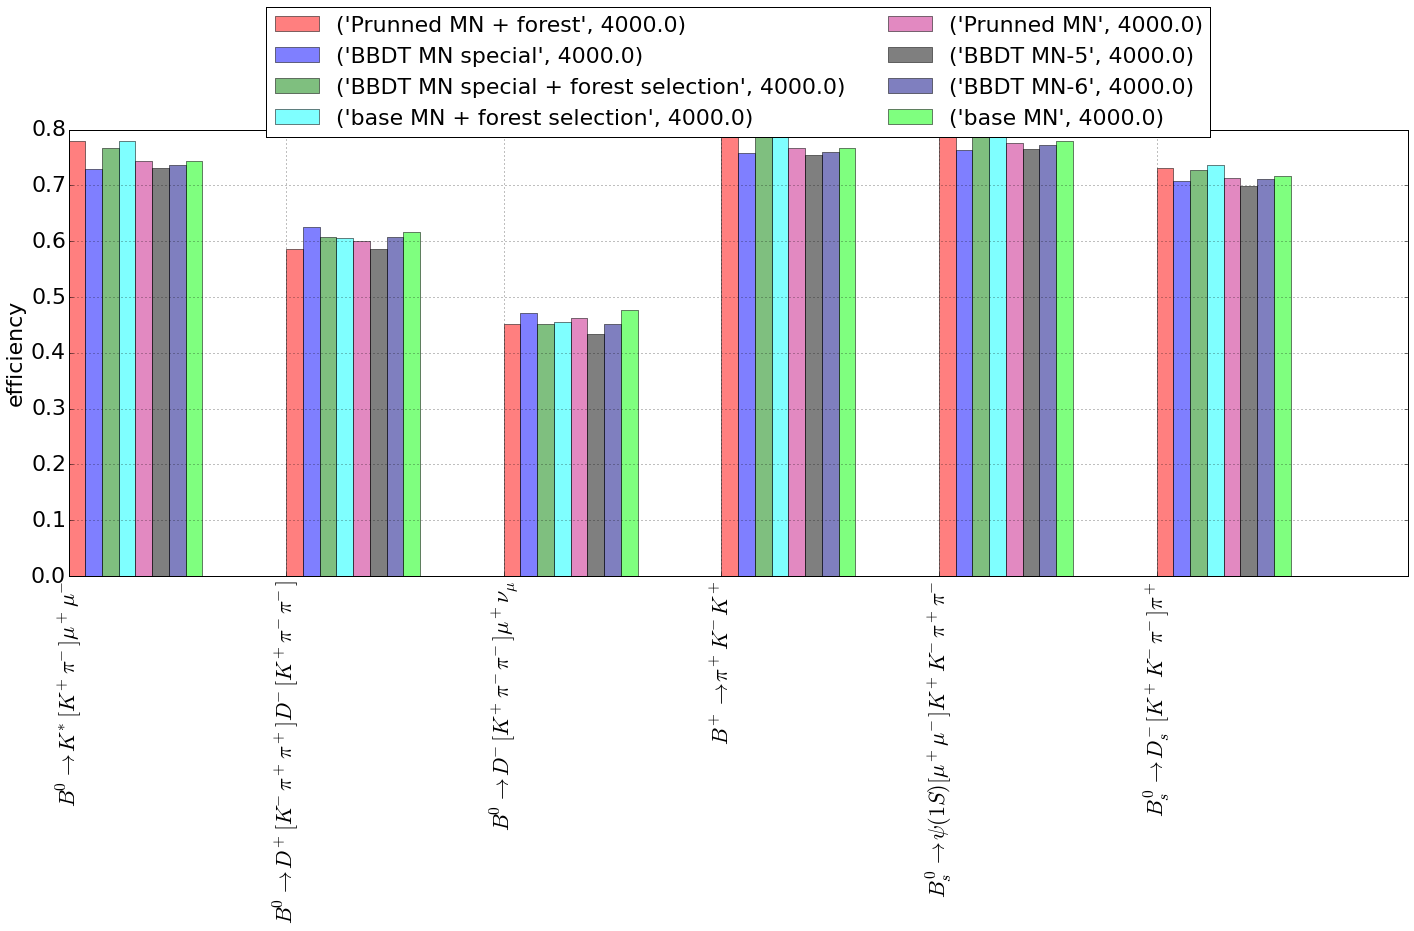

In [60]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.3), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Classification report using events

In [78]:
plots = OrderedDict()
for key, value in estimators.items():
    plots[key] = plot_roc_events(value, test[test['signal'] == 1], test[test['signal'] == 0], key)

BBDT MN-6 AUC: 0.948787065058
BBDT MN-5 AUC: 0.946395911938
BBDT MN special + forest selection AUC: 0.956026062108
base MN + forest selection AUC: 0.960070220947
Prunned MN AUC: 0.9541971288
BBDT MN special AUC: 0.952332233169
base MN AUC: 0.955959310671
Prunned MN + forest selection AUC: 0.957348255669


In [80]:
bbdt_plots = plots.copy()
bbdt_plots.pop('Prunned MN')
bbdt_plots.pop('Prunned MN + forest selection')

(array([ 0.        ,  0.        ,  0.        , ...,  0.99958609,
         0.99979305,  1.        ]),
 array([  1.54235301e-05,   2.17045426e-05,   3.71280728e-05, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00]))

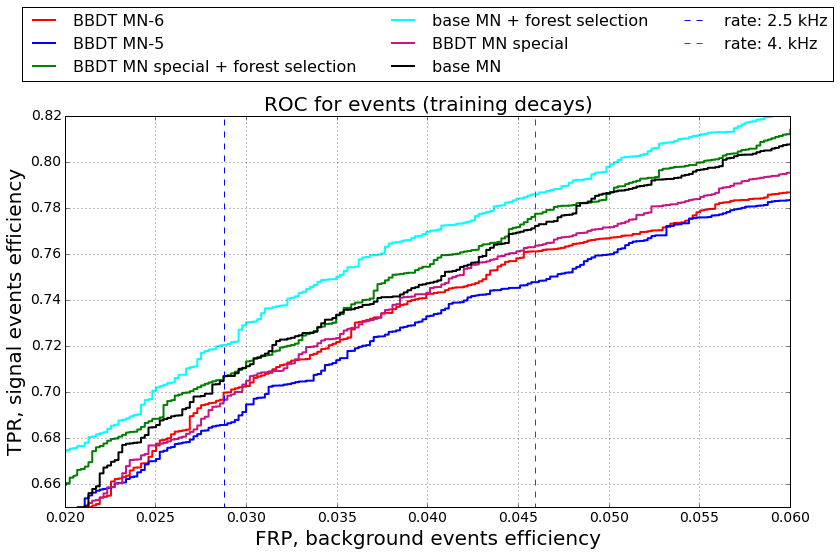

In [63]:
from rep.plotting import FunctionsPlot
FunctionsPlot(bbdt_plots).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.82))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.3), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

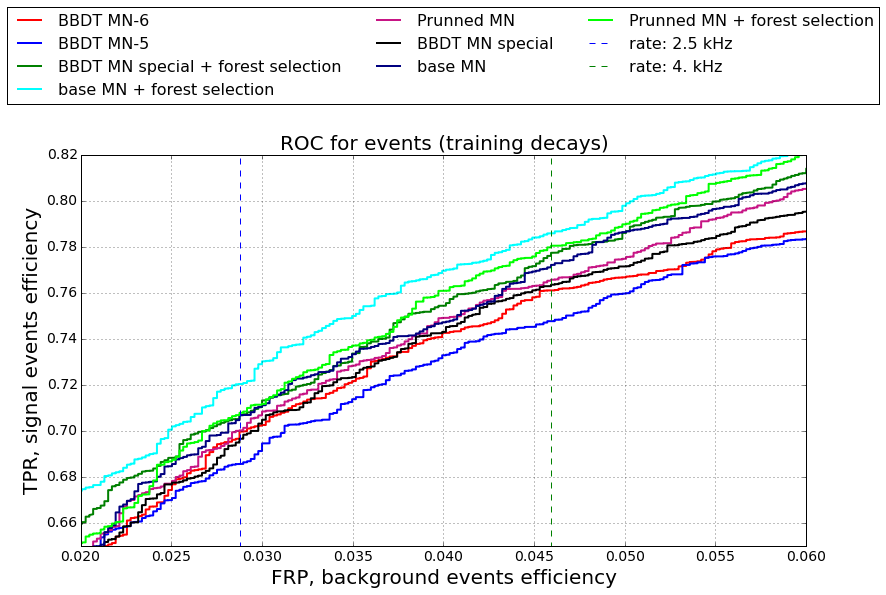

In [81]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.82))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)
plt.savefig('img/rocs_fast_training.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# all channels efficiencies

In [65]:
from collections import defaultdict
all_channels = []
efficiencies = defaultdict(OrderedDict)
for mode in empty_events.keys():
    if mode in set(sig_train_modes_names) or mode == bck_train_mode_name:
        continue
    df = pandas.read_csv(os.path.join(folder , 'mod_{}.csv'.format(mode)), sep='\t')
    if len(df) <= 0:
        continue
    total_events = statistic_length(df)['Events'] + empty_events[mode]
    df = df[(df['pass_nbody'] == 1) & (df['mcor'] <= 10e3)]
    passed_events = statistic_length(df)['Events']
    all_channels.append(df)
    for name, cl in estimators.items():
        prob = cl.predict_proba(df)
        for rate, thresh in thresholds[name].items():
            eff = final_eff_for_mode(df, prob, total_events, thresh)
            latex_name = '$' + Samples[str(mode)]['root'].replace("#", "\\") + '$'
            efficiencies[(name, rate)][latex_name] = eff

In [66]:
for key, val in efficiencies.items():
    for key_2, val_2 in val.items():
        if val_2 <= 0.1:
            efficiencies[key].pop(key_2)

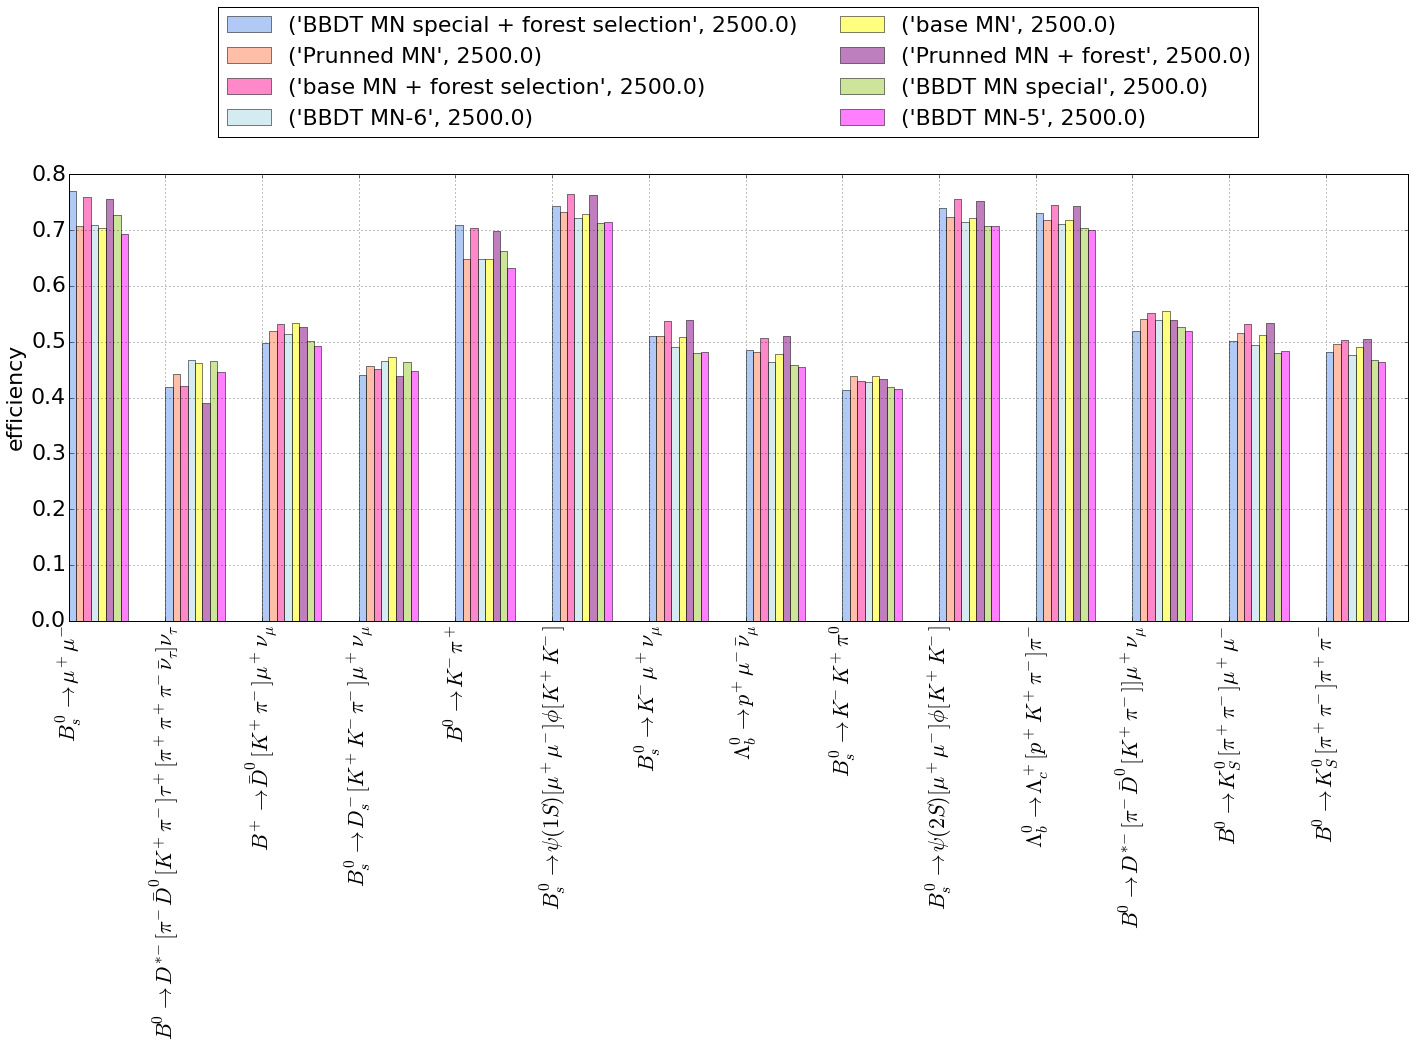

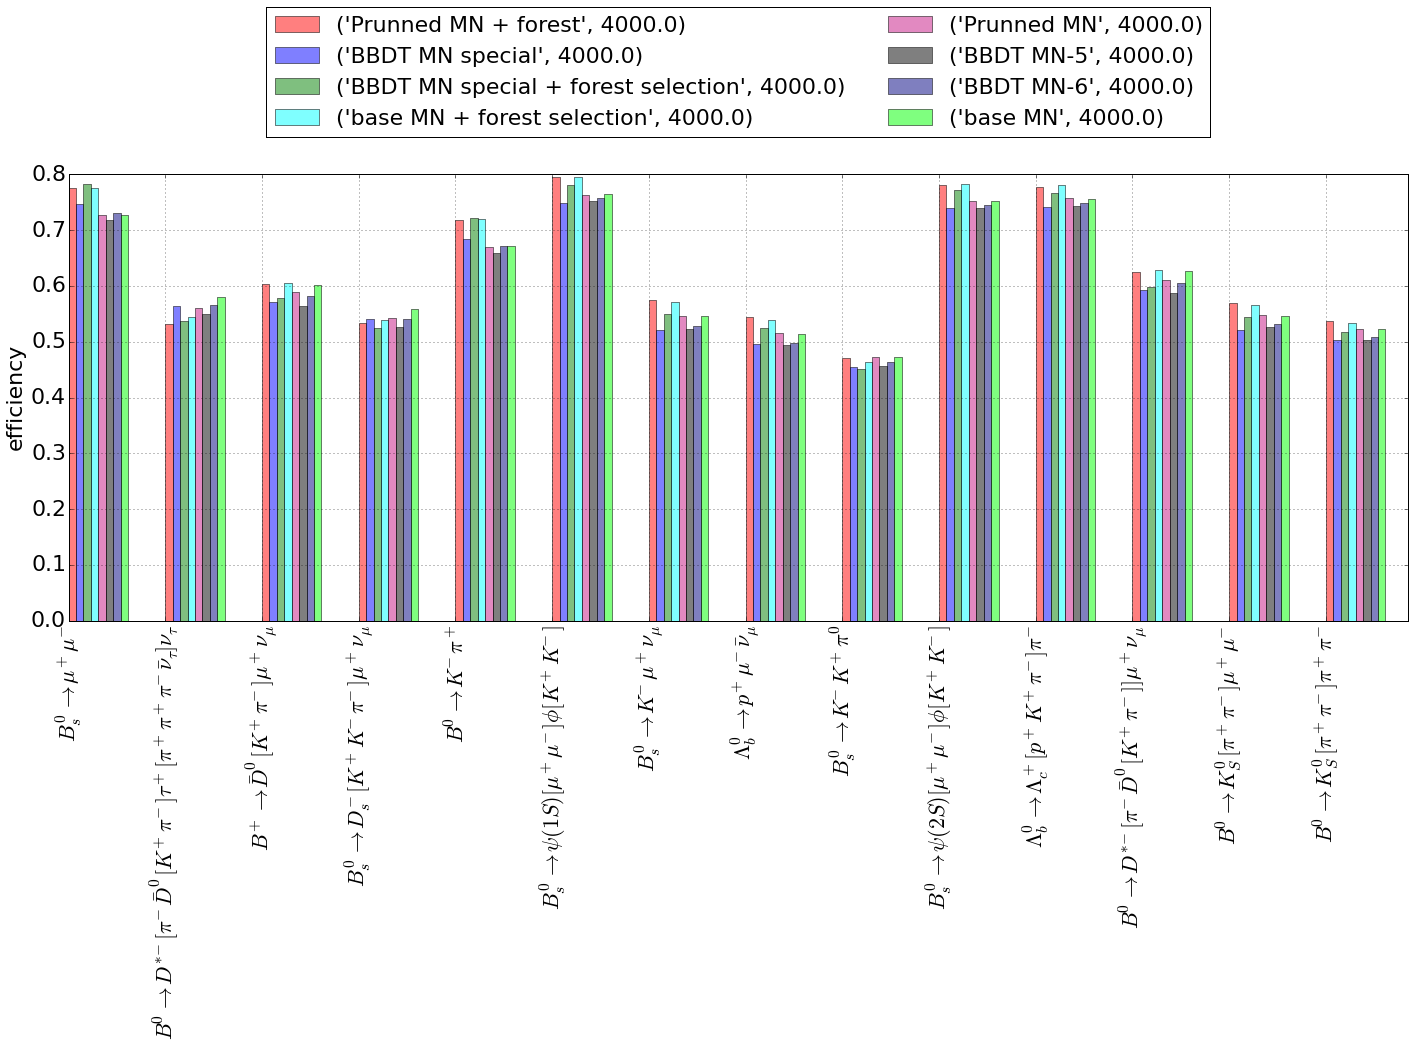

In [67]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in efficiencies.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', ncol=2, fontsize=22)

In [68]:
plots_all = OrderedDict()
for key, value in estimators.items():
    plots_all[key] = plot_roc_events(value, pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                     test[test['signal'] == 0], key)

BBDT MN-6 AUC: 0.893047340693
BBDT MN-5 AUC: 0.891496975588
BBDT MN special + forest selection AUC: 0.894347907945
base MN + forest selection AUC: 0.890762970994
Prunned MN AUC: 0.899181390133
BBDT MN special AUC: 0.896260843657
Prunned MN + forest AUC: 0.891083739409
base MN AUC: 0.897475380098


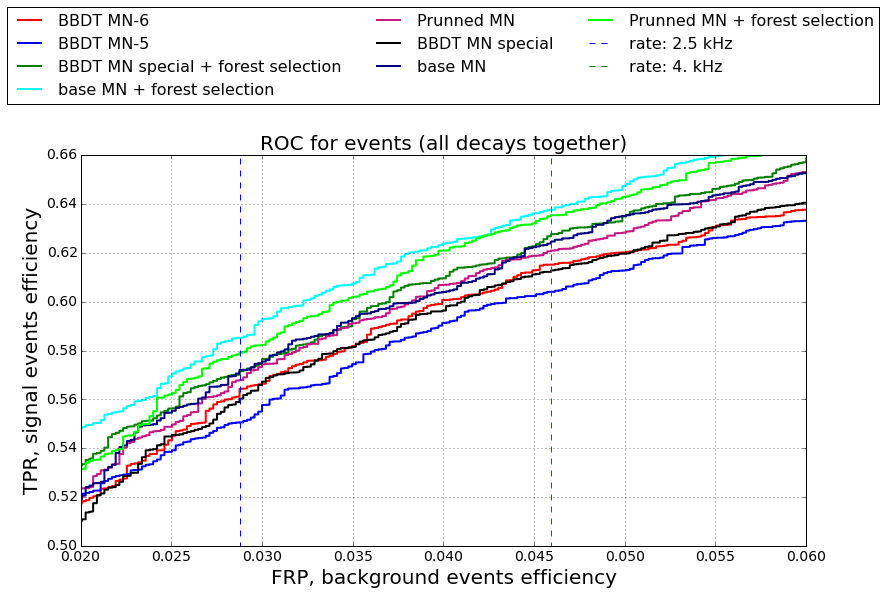

In [85]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots_all).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.5, 0.66))
plot([1. * events_pass['2500.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base MN'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (all decays together)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)
plt.savefig('img/rocs_fast_all.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# DIfferent rates

In [70]:
thresholds = OrderedDict()
RATE = [2000., 2500., 3000., 3500., 4000.]
for name, cl in estimators.items():
    prob = cl.predict_proba(ds_test_bck)
    thr, result = calculate_thresholds(ds_test_bck, prob, total_test_bck_events, rates=RATE)
    thresholds[name] = thr
    print name, result

BBDT MN-6 {2000.0: (0.9967790194752344, 111, 0.00199450164411622), 3000.0: (0.99547798927619391, 166, 0.002982768224534167), 4000.0: (0.99402680780929342, 222, 0.00398900328823244), 3500.0: (0.99472365991502065, 194, 0.003485885756383304), 2500.0: (0.99595672446060457, 139, 0.002497619175965357)}
BBDT MN-5 {2000.0: (0.99676111865222461, 111, 0.00199450164411622), 3000.0: (0.99559207475332101, 166, 0.002982768224534167), 4000.0: (0.99425757263704562, 222, 0.00398900328823244), 3500.0: (0.99487682163832258, 194, 0.003485885756383304), 2500.0: (0.99628784046073426, 139, 0.002497619175965357)}
BBDT MN special + forest selection {2000.0: (0.99071124574107072, 111, 0.00199450164411622), 3000.0: (0.98628897678207939, 166, 0.002982768224534167), 4000.0: (0.98010418304141567, 222, 0.00398900328823244), 3500.0: (0.98328751304816508, 194, 0.003485885756383304), 2500.0: (0.98834949508318237, 139, 0.002497619175965357)}
base MN + forest selection {2000.0: (0.99010737412337058, 111, 0.00199450164411

In [71]:
train_modes_eff, statistic = result_statistic({'base MN': estimators['base MN']}, sig_train_modes_names, 
                                              test[test['signal'] == 1],
                                              thresholds, RATE, total_test_signal_events)

In [72]:
order_rate = OrderedDict()
for j in numpy.argsort([i[1] for i in train_modes_eff.keys()]):
    order_rate[train_modes_eff.keys()[j]] = train_modes_eff.values()[j]

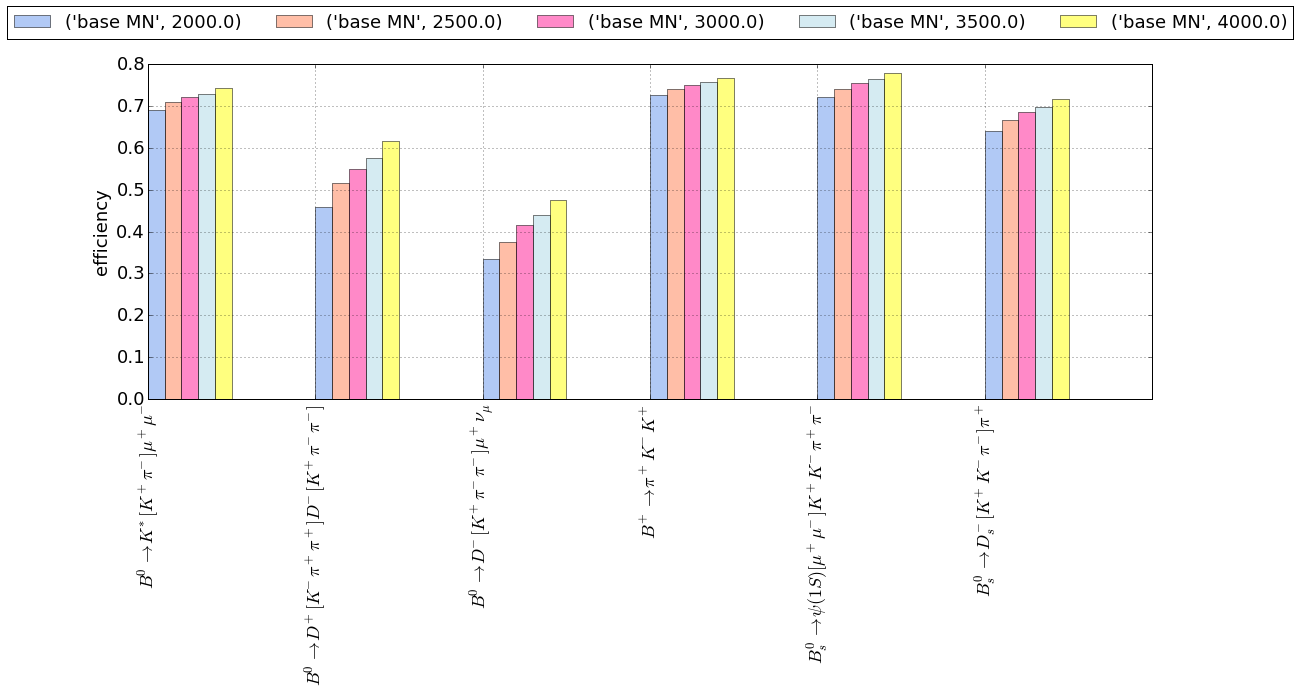

In [73]:
from rep.plotting import BarComparePlot
BarComparePlot(order_rate).plot(new_plot=True, figsize=(18, 6), ylabel='efficiency', fontsize=18)
lgd = legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=5, fontsize=18)
# plt.savefig('rates.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')